<b><font size= +2>Battle of Neghborhoods (Part 2: Data Analysis)</b></font size>





<b> CAPSTONE PROJECT: Applied Data Science </b>
<br>
<i> by Rafael M. Tiba </i>
<br><br>

<u> <font size= +1>Where to open a new Pizza Place in NY ? </u></font size>
<br>

<b> INTRODUCTION: </b> <br>

This final project will use knowledge on Data Science to find the best locations for Pizza Places throughout New York.

<br>
New York has approximately 20,000,000 restaurants so if one wants to open a new one, data driven decisions will be of paramount importance. In the present work, data from foursquare will be scraped to yield a complete analysis on the competitors in the pizza places business. 
<br><br>
As of the present date, a google search for "Best Pizza in New York"resulted in at least 10 rankings from different sites and no consensus have been observed. Without the knowledge of data science tools, one could again, google "how many pizza places are there in new york" and get a wild variety of answers from quora, reddit, business insider and so on.
<br>
No reliable or easy to find answer is available even though all data is there!
<br>

<b> DATA: </b> <br><br>

In order to find relevant information regarding where to open a new pizza place, data on New York City is required. Specifically, data regarding neighborhoods, boroughs, venues' latitudes, longitudes, and venues numbers of likes.
<br><br>
NY data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset
<br><br>
NY data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
<br><br>
All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API.
<br>

<b> METHODOLOGY: </b> <br>
<br><br><i> Part 1: Data gathering and cleansing </i><br><br>
• Data will be collected from https://cocl.us/new_york_dataset <br>
• Fousquare API will be called to locate all pizza places in NY <br>
• Also, Foursquare API will be used to retrieve total amount of likes for each property in the last year <br>
• All data will be cleaned and processed into a dataframe. <br>
<br><br><i> Part 2: Data Analysis </i><br><br>
• Pizza places numbers will be consolidated by Borough and Neighborhood<br>
• Basic Graphical analysis will be used to compare Boroughs regarding amount of Pizza Places<br>
• Top/Bottom 10 analysis will be used to screen top venues (and also the worst ones) to provide a list of potential properties that should be visited as benchmarks<br>
<br><br><i> Part 3: Narrowing Down </i><br><br>
• Due to restrictions imposed by Foursquare API, that limit the number of premium calls per day, we will use the number of likes as one of indicators of popularity, even though this could be distorted by new pizza places or places with more or less space to accomodate gests. <br>
• In part 3, we will be narrowing down to Manhattan, there we will search for top performer (most likes) and bottom performer (least likes) <br>
• Likes will be consolidated in Manhattan's Neighborhoods to analyze top performers competitors (more likes = more popularity)<br>
• Number of venues will be consolidate to show which neighborhoods have more competitors <br>
• A market index will be created combining both two info above (MKT_INDEX)<br>
• And finnaly, a choropleth map will be created showing these results
<br>

<b>HERE WE GO!</b>

In [2]:
# importing Libraries
import pandas as pd
import numpy as np
import requests
import os
!pip install folium
import folium
!pip install geopy.geocoders
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries Imported successfully. Ready to go')

You should consider upgrading via the 'pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement geopy.geocoders (from versions: none)
ERROR: No matching distribution found for geopy.geocoders
You should consider upgrading via the 'pip install --upgrade pip' command.
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pytest-doctestplus==0.1.3=py36_0
  - defaults/linux-64::patsy==0.5.1=py36_0
  - defaults/linux-64::pytest-arraydiff==0.2=py36h39e3cac_0
  - defaults/linux-64::hdmedians==0.13=py36h035aef0_0
  - defaults/linux-64::scikit-learn==0.19.2=py37h4989274_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::blaze==0.11.3=py36_0
  - https://repo.anaconda.com/pkgs/free/linux-64::pymc==2.3.6=np111py36_2
  - defaults/linux-64::pandasql==0.7.3=py36_1
  - defaults/linux-64::mkl_random==1.0.1=py36h4414c95_1
  -

<br><br><i> Part 1: Data gathering and cleansing </i><br><br>

In [3]:
# GETTING NY Data from cocl.us
url='https://cocl.us/new_york_dataset'
    
resp=requests.get(url).json()
features=resp['features']
    
# dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
ny_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    ny_data = ny_data.append({'Borough': borough,
                                  'Neighborhood': neighborhood_name,
                                  'Latitude': neighborhood_lat,
                                  'Longitude': neighborhood_lon}, 
                                   ignore_index=True)
df_ny = ny_data
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
# Function for coordinates

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [25]:
# Function for getting venues from Foursquare API

def get_venues(lat,lng):
    radius=500
    LIMIT=100
    CLIENT_ID = '3N3VC04SQRMRCDPZDA2YISISVWJRWYOTXBP2B33HOB53JMG3' # my Foursquare ID
    CLIENT_SECRET = 'LMMUKVZ01GSIMFPZRVQTXW3WGAEAAHP2AIWQNSMJQ1F1LH34' # please don't look...
    VERSION = '20180605' # Foursquare API version

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
                pass

    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
# Function to get venue likes (not premium call)

def get_venue_likes(venue_id):
        
    CLIENT_ID = '3N3VC04SQRMRCDPZDA2YISISVWJRWYOTXBP2B33HOB53JMG3'
    CLIENT_SECRET = 'LMMUKVZ01GSIMFPZRVQTXW3WGAEAAHP2AIWQNSMJQ1F1LH34'
    VERSION = '20180605' # Foursquare API version
    
    #startat = '1546304401' # always jan first 2019
    #endat = '1577840401'# always jan first 2020
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}/likes/?client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get data
    results = requests.get(url).json()
    venue_data=results['response']
    venue_details=[]
    try:
        venue_likes=venue_data['likes']['count']
        venue_details.append([venue_id,venue_likes])
    except KeyError:
        pass
        
    column_names=['ID','Likes']    
    
    dflike = pd.DataFrame(venue_details, columns=column_names)
    
    return dflike


In [16]:
#TESTING FUNCTION... 
        
CLIENT_ID = '3N3VC04SQRMRCDPZDA2YISISVWJRWYOTXBP2B33HOB53JMG3'
CLIENT_SECRET = 'LMMUKVZ01GSIMFPZRVQTXW3WGAEAAHP2AIWQNSMJQ1F1LH34'
VERSION = '20180605' # Foursquare API version
venue_id='4b6dbb78f964a520968a2ce3' # a dominos restaurant just to test the function ...
    
#url to fetch data from foursquare api
url = 'https://api.foursquare.com/v2/venues/{}/likes/?client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
print(url)
results = requests.get(url).json()
venue_data=results['response']
venue_details=[]
try:
    venue_likes=venue_data['likes']['count']
    venue_details.append([venue_id,venue_likes])
except KeyError:
    pass
        
column_names=['ID','Likes']    
dflike = pd.DataFrame(venue_details, columns=column_names)
dflike.head()


https://api.foursquare.com/v2/venues/4b6dbb78f964a520968a2ce3/likes/?client_id=3N3VC04SQRMRCDPZDA2YISISVWJRWYOTXBP2B33HOB53JMG3&client_secret=LMMUKVZ01GSIMFPZRVQTXW3WGAEAAHP2AIWQNSMJQ1F1LH34&v=20180605


,ID,Likes
0,4b6dbb78f964a520968a2ce3,1


Ok, fuction seems to be working.

In [7]:
#Now we get a list of all pizza places in NY

vns = get_venues(40.898271,-73.867316)
vns[vns['Category']=='Pizza Place']

pizza_places = vns[vns['Category']=='Pizza Place'].values.tolist()
pizza_places


[['4ba50da6f964a52046d638e3', 'Katonah Pizza and Pasta', 'Pizza Place'],
 ['4c24dd02a852c928c1cee36c', "Angelo's Pizza", 'Pizza Place']]

In [8]:
len(vns[vns['Category']=='Pizza Place'].values.tolist()) > 0

True

In [9]:
# Lets take a quick look into the list:
for row in df_ny.values.tolist():
    print(row)

['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
['Bronx', 'Williamsbridge', 40.88103887819211, -73.85744642974207]
['Bronx', 'Baychester', 40.866858107252696, -73.83579759808117]
['Bronx', 'Pelham Parkway', 40.85741349808865, -73.85475564017999]
['Bronx', 'City Island', 40.84724670491813, -73.78648845267413]
['Bronx', 'Bedford Park', 40.870185164975325, -73.8855121841913]
['Bronx', 'University Heights', 40.85572707719664, -73.9104159619131]
['Bronx', 'Morris Heights', 40.847897926

In [27]:
# prepare neighborhood list that contains pizza places

column_names=['Borough', 'Neighborhood', 'ID','Name']
pizza_places_ny=pd.DataFrame(columns=column_names)


print('Pizza Places in\n---------------------')

for row in df_ny.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    pizza_places=venues[venues['Category']=='Pizza Place']
   
    if len(pizza_places) > 0:
        print(Neighborhood+', '+Borough+' : '+str(len(pizza_places)))
    
    
    for restaurant_detail in pizza_places.values.tolist():
        id, name , category=restaurant_detail
        pizza_places_ny = pizza_places_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
        
print('Done listing Pizza Places in NY')

Pizza Places in
---------------------
Co-op City, Bronx : 1
Eastchester, Bronx : 1
Kingsbridge, Bronx : 5
Marble Hill, Manhattan : 1
Woodlawn, Bronx : 4
Norwood, Bronx : 5
Baychester, Bronx : 1
Pelham Parkway, Bronx : 2
City Island, Bronx : 1
Bedford Park, Bronx : 4
University Heights, Bronx : 3
Morris Heights, Bronx : 1
Fordham, Bronx : 3
East Tremont, Bronx : 3
West Farms, Bronx : 1
High  Bridge, Bronx : 3
Melrose, Bronx : 4
Mott Haven, Bronx : 2
Hunts Point, Bronx : 1
Morrisania, Bronx : 1
Throgs Neck, Bronx : 1
Parkchester, Bronx : 3
Westchester Square, Bronx : 2
Van Nest, Bronx : 4
Morris Park, Bronx : 5
Belmont, Bronx : 9
Spuyten Duyvil, Bronx : 1
North Riverdale, Bronx : 3
Schuylerville, Bronx : 2
Edgewater Park, Bronx : 2
Castle Hill, Bronx : 2
Pelham Gardens, Bronx : 1
Concourse, Bronx : 3
Unionport, Bronx : 1
Bay Ridge, Brooklyn : 4
Bensonhurst, Brooklyn : 3
Sunset Park, Brooklyn : 3
Greenpoint, Brooklyn : 6
Gravesend, Brooklyn : 3
Sheepshead Bay, Brooklyn : 1
Manhattan Terra

In [28]:
pizza_places_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4d2cfa5cad25224bbbc5fb8f,Capri II Pizza
1,Bronx,Eastchester,4c632f1cde1b2d7fed31e470,Mario's Pizza
2,Bronx,Kingsbridge,58935fd798f8aa7c14662653,Kingsbridge Social Club
3,Bronx,Kingsbridge,4bb114c4f964a520b9783ce3,Sam's Pizza
4,Bronx,Kingsbridge,4be72770910020a16f1ad514,Broadway Pizza & Pasta


<br><br><i> Part 2: Data Analysis </i><br><br>

In [29]:
# So, how many pizza places in NY ??
pizza_places_ny.shape

(437, 4)

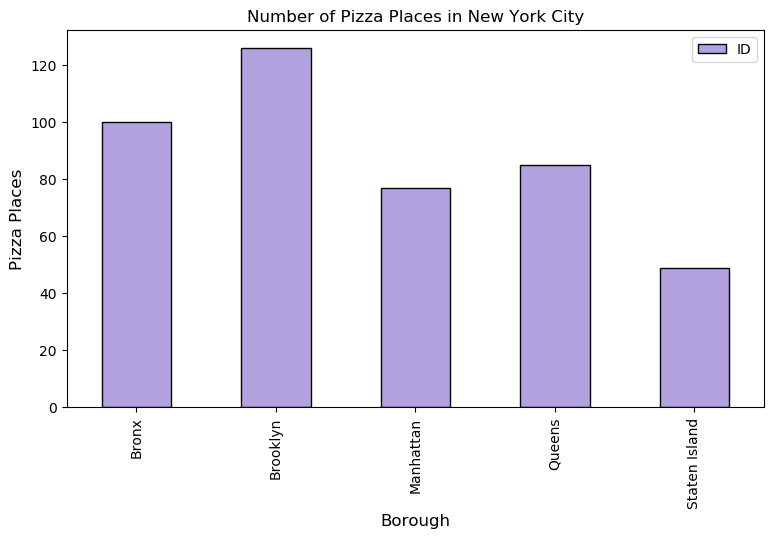

In [30]:
# Viewing pizza places per Borough

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Pizza Places in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('Pizza Places', fontsize=12)
#giving a bar plot
pizza_places_ny.groupby('Borough')['ID'].count().plot(kind='bar', 
                                                      color=(0.5, 0.4, 0.8, 0.6),
                                                      edgecolor='black')
#legend
plt.legend()
#displays the plot
plt.show()

<b>OBSERVATION 1:</b> Manhattan is the 4th place in number of pizza places. It may be interesting to focus analysis there.

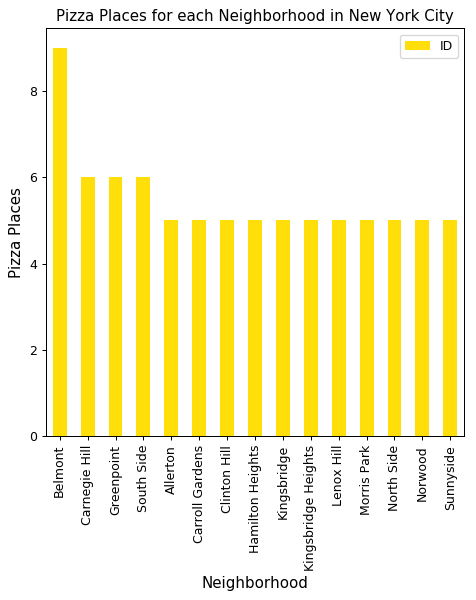

ID    2.0
dtype: float64


In [58]:
# Let's see the top 10 neighborhoods now...
plt.figure(figsize=(6,6), dpi = 90)
# title
plt.title('Pizza Places for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('Pizza Places', fontsize=12)
#giving a bar plot
pizza_places_ny.groupby('Neighborhood')['ID'].count().nlargest(15).plot(kind='bar', color='#FFDE09')
#legend
plt.legend()
#displays the plot
plt.show()

dftemp=pd.DataFrame(pizza_places_ny.groupby('Neighborhood')['ID'].count())
print(dftemp.median(axis=0))


<b>OBSERVATION 2:</b> In Median, each neigborhood has 2 pizza places. whilst Belmont has 8...

In [63]:
#Amazing!! Belmont alone has 9 Pizza Places ...

# As stated before, from now on, we will be focusing on venues in Manhattan.

pizza_places_manh = pizza_places_ny.loc[pizza_places_ny['Borough'] == 'Manhattan']

print(pizza_places_manh.shape)
pizza_places_manh.head()

(77, 4)


,Borough,Neighborhood,ID,Name
7,Manhattan,Marble Hill,4b4429abf964a52037f225e3,Arturo's
196,Manhattan,Chinatown,56c3c626cd106998d2b196d0,Scarr's Pizza
197,Manhattan,Washington Heights,5503762d498e150bef780584,Fresco's Pizzeria
198,Manhattan,Washington Heights,4fb6848be4b07a70ece42bd5,Papi's Pizzeria
199,Manhattan,Inwood,4ab97430f964a520727f20e3,Grandpa's Brick Oven Pizza


In [36]:
# Now, preparing a neighborhood list that contains pizza places and likes

column_names=['ID','Likes']
pizza_places_likes_manh=pd.DataFrame(columns=column_names)

count=1

for row in pizza_places_manh.values.tolist():
    Borough,Neighborhood,ID,Name = row
    
    try:
       venue_likes = get_venue_likes(ID)
       id, likes = venue_likes.values.tolist()[0]
   
    
    except IndexError:
        print('No data available for id=',ID)
        # Assign 0 value for not found on database
        id,likes=[0]*2
    
   
    # print('(',count,'/',len(pizza_places_ny),')','processed')
    pizza_places_likes_manh = pizza_places_likes_manh.append({'ID': id,
                                                'Likes' : likes,
                                               }, ignore_index=True)
    count+=1

pizza_places_likes_manh.head()

,ID,Likes
0,4b4429abf964a52037f225e3,16
1,56c3c626cd106998d2b196d0,229
2,5503762d498e150bef780584,28
3,4fb6848be4b07a70ece42bd5,2
4,4ab97430f964a520727f20e3,28


<b>Now, we just have to join dataframes to have the complete scenario </b>

Lets make a Join for GPS Coordinates, Venue details and likes.
Just to clarify, the information we need is on the following dataframes:
- GPS coordinates for Neighborhoods are on: <b>df_ny</b>
- Venue details on: <b>pizza_places_manh</b>
- Amount of likes is on : <b>pizza_places_likes_manh</b>


In [37]:
# Joining places & Likes!

manh_venues_likes=pd.merge(pizza_places_manh,pizza_places_likes_manh, on="ID")
manh_venues_likes.head()

,Borough,Neighborhood,ID,Name,Likes
0,Manhattan,Marble Hill,4b4429abf964a52037f225e3,Arturo's,16
1,Manhattan,Chinatown,56c3c626cd106998d2b196d0,Scarr's Pizza,229
2,Manhattan,Washington Heights,5503762d498e150bef780584,Fresco's Pizzeria,28
3,Manhattan,Washington Heights,4fb6848be4b07a70ece42bd5,Papi's Pizzeria,2
4,Manhattan,Inwood,4ab97430f964a520727f20e3,Grandpa's Brick Oven Pizza,28


<b>Lets save it to CSV! </b>

In [38]:
manh_venues_likes.to_csv('manhattan_pizza_places.csv', index=True)

<b>#Lets see the final dataframe and convert it to floats</b>

In [39]:
convert_types = { 'Likes': float }
manh_venues_likes = manh_venues_likes.astype(convert_types)
manh_venues_likes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Data columns (total 5 columns):
Borough         85 non-null object
Neighborhood    85 non-null object
ID              85 non-null object
Name            85 non-null object
Likes           85 non-null float64
dtypes: float64(1), object(4)
memory usage: 4.0+ KB


<br><br><i> Part 3: Narrowing Down </i><br><br>

<b> And the Pizza Place with most likes in all manhattan is: </b>

In [40]:
manh_venues_likes.iloc[manh_venues_likes['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              55ea9f4d498ed46db0383483
Name                      Champion Pizza
Likes                               1262
Name: 50, dtype: object

<br>Good for you, Champion PIZZA. <br> <br>
<b> OBSERVATION 3</b>: We shall do a Benchmark on Champion Pizza to gather info on why they are so... well... champions. (sorry about that) <br>

ON the other hand, the less liked Pizza Place in all manhattan is:

In [41]:
manh_venues_likes.iloc[manh_venues_likes['Likes'].idxmin()]

Borough                        Manhattan
Neighborhood            Hamilton Heights
ID              5812ea4538fa932fe0cc3951
Name                   Papa John's Pizza
Likes                                  0
Name: 9, dtype: object

Ok, that wasn't necessary but I was curious :). Also, difficult to believe that a papa john's has so low score, probably has opened recently.

<b>Now, lets create a dataset with the average number of likes of all restaurants in each neighborhood</b>

In [42]:
grouped_venues=manh_venues_likes.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Likes']]
grouped_venues.columns=['Neighborhood','Likes']

<b>And if you want to eat a good pizza, your chances are better at those neighborhoods:</b>

In [44]:
grouped_venues.rename(columns={"Likes":"Average Likes per Venue"},inplace = True)
grouped_venues.sort_values(['Average Likes per Venue'],ascending=False).head(10)

,Neighborhood,Average Likes per Venue
3,Chelsea,930.00
24,Soho,807.50
14,Little Italy,807.50
31,West Village,670.00
10,Greenwich Village,319.00
7,East Village,245.75
4,Chinatown,229.00
5,Clinton,195.00
8,Financial District,190.25
20,Morningside Heights,178.00


<b>OBSERVATION 4</b>: Chelsea, Soho and Little Italy are the top 3 Neighborhoods in which we could expect facing strong competitors

<b> Let's add the number of venues to the analysis </b>

Let's find out in which neighborhoods we could find more competitors

In [59]:
number_venues=manh_venues_likes.groupby('Neighborhood',as_index=False).count()[['Neighborhood','ID']]
manh_venues_stats=pd.merge(number_venues,grouped_venues, on="Neighborhood")
manh_venues_stats.rename(columns={"ID":"Count of Venues"},inplace = True)
manh_venues_stats.sort_values(['Count of Venues'],ascending=False).head(10)

,Neighborhood,Count of Venues,Average Likes per Venue
1,Carnegie Hill,6,97.166667
13,Lenox Hill,5,37.600000
26,Tudor City,5,94.200000
11,Hamilton Heights,5,9.600000
32,Yorkville,4,29.500000
24,Soho,4,807.500000
7,East Village,4,245.750000
8,Financial District,4,190.250000
9,Gramercy,4,117.250000
14,Little Italy,4,807.500000


<b>OBSERVATION 5</b>: Carnegie Hill, Lenox Hill and Tudor City are the top 3 Neighborhoods in which we could expect facing more competitors.

<b> In order to analyze on the map, lets add coordinates</b>

In [64]:
df_ny_manh=df_ny.loc[df_ny['Borough'] == 'Manhattan']

manh_venues_stats_df=pd.merge(manh_venues_stats,df_ny_manh, on='Neighborhood')
manh_venues_stats_df.head()

,Neighborhood,Count of Venues,Average Likes per Venue,Borough,Latitude,Longitude
0,Battery Park City,2,126.500000,Manhattan,40.711932,-74.016869
1,Carnegie Hill,6,97.166667,Manhattan,40.782683,-73.953256
2,Central Harlem,2,9.000000,Manhattan,40.815976,-73.943211
3,Chelsea,1,930.000000,Manhattan,40.744035,-74.003116
4,Chinatown,1,229.000000,Manhattan,40.715618,-73.994279


<b> So let's get some important insights and wrap it up </b>

In [104]:
# First of all, lets create a potential market index which combines both Count of venues and Average likes per venue (ALV).
# It will be a combination of standardized venues per neighborhood times standardized ALV.

# Slicing
manh_venues_std = manh_venues_stats_df[['Neighborhood', 'Count of Venues', 'Average Likes per Venue', 'Latitude', 'Longitude']]
manh_venues_std.head()

# Creating standardized variables (maximum = 1)
STD_Count = manh_venues_std['Count of Venues']/manh_venues_std['Count of Venues'].max()
STD_ALV = manh_venues_std['Average Likes per Venue']/manh_venues_std['Average Likes per Venue'].max()

# Appending to DF
manh_venues_std['STD_Count'] = STD_Count
manh_venues_std['STD_ALV'] = STD_ALV
manh_venues_std['Competition']=manh_venues_std['STD_Count'] * manh_venues_std['STD_ALV']

manh_venues_std.head()

,Neighborhood,Count of Venues,Average Likes per Venue,Latitude,Longitude,STD_Count,STD_ALV,Competition
0,Battery Park City,2,126.500000,40.711932,-74.016869,0.333333,0.136022,0.045341
1,Carnegie Hill,6,97.166667,40.782683,-73.953256,1.000000,0.104480,0.104480
2,Central Harlem,2,9.000000,40.815976,-73.943211,0.333333,0.009677,0.003226
3,Chelsea,1,930.000000,40.744035,-74.003116,0.166667,1.000000,0.166667
4,Chinatown,1,229.000000,40.715618,-73.994279,0.166667,0.246237,0.041039


In [105]:
# Dropping unused columns:

manh_venues_std=manh_venues_std.drop(['STD_Count', 'STD_ALV', 'Count of Venues','Average Likes per Venue'],axis=1)
manh_venues_std.head()

,Neighborhood,Latitude,Longitude,Competition
0,Battery Park City,40.711932,-74.016869,0.045341
1,Carnegie Hill,40.782683,-73.953256,0.104480
2,Central Harlem,40.815976,-73.943211,0.003226
3,Chelsea,40.744035,-74.003116,0.166667
4,Chinatown,40.715618,-73.994279,0.041039


<br><br>
<b>Lets see the top 5 neighborhoods in manhattan for opening a pizza place!</b><br>

In [108]:
manh_venues_std.sort_values(['Competition'],ascending=True).head(5)
# Acending order because the lower the competition, the better....

,Neighborhood,Latitude,Longitude,Competition
23,Roosevelt Island,40.762160,-73.949168,0.001075
17,Marble Hill,40.876551,-73.910660,0.002867
2,Central Harlem,40.815976,-73.943211,0.003226
18,Midtown,40.754691,-73.981669,0.003763
6,East Harlem,40.792249,-73.944182,0.003943


<b>OBSERVATION 6</b>: Those are the top 5 Neighborhoods to open a pizza place: Roosevelt Island, Marble Hill, Central Harlem, Midtown and East Harlem.

In [109]:
import folium

In [146]:
# Lets see index per neighbourhood

# Manhattan coordinates
manh_lat = 40.7831
manh_long = -73.9712

# Create a new map
manh_map = folium.Map(
            location = [manh_lat, manh_long],
            zoom_start = 12)

# add marker one by one on the map
for i in range(0,len(manh_venues_std)):
   folium.CircleMarker(
    location=[manh_venues_std.iloc[i]['Latitude'], manh_venues_std.iloc[i]['Longitude']],
    radius=manh_venues_std.iloc[i]['Competition']*3000,
    #popup=manh_venues_std.iloc[i]['Neighborhood'],
    color='#3186cc',
    #fill=False,
   # fill_color='#3186cc'
   ).add_to(manh_map)

manh_map

<b>OBSERVATION 7</b>: The most promissing neighbourhoods are those that have smaller circles. Areas with huge circles have lots of competitors either on amount or popularity (number of likes)

<br><b><font size= +2>RESULTS </b></font size>
<br>
<br>
<br>
<i>Here is the list of insights gathered throughout the process: </i><br>

<b>OBSERVATION 1:</b> Manhattan is the 4th place in number of pizza places. It may be interesting to focus analysis there.<br><br>
<b>OBSERVATION 2:</b> In Median, each neigborhood has 2 pizza places. whilst Belmont has 8...<br><br>
<b> OBSERVATION 3</b>: We shall do a Benchmark on Champion Pizza to gather info on why they are so... well... champions. (sorry about that) <br><br>
<b>OBSERVATION 4</b>: Chelsea, Soho and Little Italy are the top 3 Neighborhoods in which we could expect facing strong competitors<br><br>
<b>OBSERVATION 5</b>: Carnegie Hill, Lenox Hill and Tudor City are the top 3 Neighborhoods in which we could expect facing more competitors.<br><br>
<b>OBSERVATION 6</b>: Those are the top 5 Neighborhoods to open a pizza place: Roosevelt Island, Marble Hill, Central Harlem, Midtown and East Harlem.<br><br>
<b>OBSERVATION 7</b>: The most promissing neighbourhoods are those that have smaller circles. Areas with huge circles have lots of competitors either on amount or popularity (number of likes)<br><br><br>


<br><b><font size= +2>CONCLUSION </b></font size>
<br>
<br>Using some of the most important Python Data Science Tools it was possible to gather data from New York City and create an observation list that could help a potential entrepreneurer seeking a good neighborhood to open a pizza place in Manhattan. Although compreensible, viewing data in the format of Dataframe Top 10 is no match for viewing it on Chropleth MAPS since they make data visualization easier to understand <br>
<br>
<i>Also, if you stop by NYC, you should visit The "Champion Pizza" due to its remarkable results on number of likes in NYC    :)<br>
<br>    Thank you so much for reviewing my work and good luck!
</i><br>